In [1]:
import sympy as smp
import matplotlib.pyplot as plt
smp.init_printing(use_latex='mathjax')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
from xnp import *
backend = 'cupy' if getattr(np, '__name__', '') == 'cupy' else 'numpy'
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

Using NumPy and SciPy on CPU


In [2]:
#Lets find some entropy

In [3]:
rmax = 1000000000
num = 500

In [4]:
#lets do a 4d planar BH
d=4
k=0
#placeholders for other vars
# the issue with these guys is that i have absolutely zero clue what "sensible" values would be for these
l=1
q=0

In [5]:
#lets define some functions?
def mu(R,d=d,k=k,l=l,q=q):
    return (R**(d-2))*(k+(q**2)/(R**(2*d-4))+(R**2)/(l**2))
def f(r,R,l=l,q=q,d=d,k=k):
    return k - mu(R)/(r**(d-2)) + (q**2)/(r**(2*d-4)) + (r**2)/(l**2)

def fp(r,R,l=l,q=q,d=d):
    return (d-2)*mu(R,d,k,l,q)/(r**(d-3)) + (4-2*d)*(q**2)/(r**(2*d-5))+ 2*r/(l**2)

def beta(R):
    return 4 * np.pi / fp(R,R)

def gamma2(r0,R):
    return -1*f(r0,R)*(r0**(2*d-4))

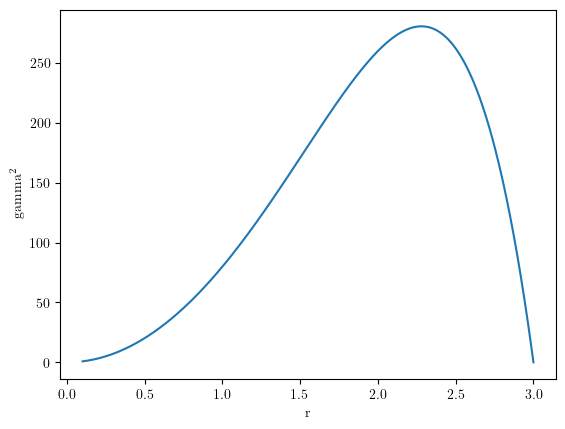

In [7]:
plt.plot(np.linspace(0.1,3,1000),gamma2(np.linspace(0.1,3,1000),3))
plt.ylabel(r'gamma$^2$')
plt.xlabel('r')
plt.show()

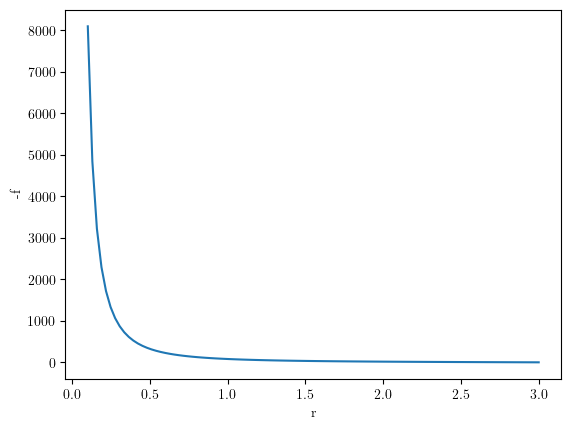

In [10]:
plt.plot(np.linspace(0.1,3,100),-f(np.linspace(0.1,3,100),3))
# plt.semilogy()
plt.ylabel('-f')
plt.xlabel("r")
plt.show()

In [12]:
#lets get a nice correlation between alpha and r0
# tried to keep this all vectorized, but was getting weird outputs and not the right divergences so its time for for loops (yippee!!!)
def k1(r0grid,R):
    list = []
    for i in range(num):
        r0 = r0grid[i]
        rbar = 1#R / 2
        rgrid = np.linspace(rbar,r0,num)
        integ = 1/f(rgrid,R)
        mask = np.isfinite(integ)
        sum =  (4 * np.pi / beta(R)) * np.trapz(integ[mask],rgrid[mask])
        list.append(sum)
    return np.array(list)

def k2(r0grid,R):
    list = []
    for i in range(num):
        r0 = r0grid[i]
        rgrid = np.logspace(np.log10(R+0.001),np.log10(rmax),num)
        integ = (1 - 1/(np.sqrt(1+f(rgrid,R)*(rgrid**(2*d-4))/(gamma2(r0,R)))))/f(rgrid,R)
        mask = np.isfinite(integ)
        sum = (2*np.pi/beta(R)) * np.trapz(integ[mask],rgrid[mask])
        list.append(sum)
    return np.array(list)

def k3(r0grid,R):
    list = []
    for i in range(num):
        r0 = r0grid[i]
        rgrid = np.linspace(r0,R-0.1,num)
        integ = (1 - 1/(np.sqrt(1+f(rgrid,R)*(rgrid**(2*d-4))/(gamma2(r0,R))))/f(rgrid,R))
        mask = np.isfinite(integ)
        sum = (4*np.pi/beta(R)) * np.trapz(integ[mask],rgrid[mask])
        list.append(sum)
    return np.array(list)

In [13]:
# ok debug thoughts
# why is the expression inside the sqrt negative for most of the interior??
# could either take real component or ignore nans like i am now, both feel hacky and not great
# what do i do???

In [14]:
R=3
r0=2
rgrid=np.linspace(r0,R,100)
1+f(rgrid,R)*(rgrid**(2*d-4))/(gamma2(r0,R))

array([ 0.        , -0.00506517, -0.01000172, -0.01480574, -0.01947328,
       -0.02400034, -0.02838285, -0.03261667, -0.03669761, -0.04062141,
       -0.04438376, -0.04798029, -0.05140654, -0.054658  , -0.05773012,
       -0.06061824, -0.06331766, -0.06582362, -0.06813127, -0.0702357 ,
       -0.07213195, -0.07381497, -0.07527965, -0.0765208 , -0.07753316,
       -0.07831141, -0.07885014, -0.07914389, -0.07918711, -0.07897417,
       -0.07849939, -0.07775698, -0.07674109, -0.07544582, -0.07386514,
       -0.07199297, -0.06982317, -0.06734947, -0.06456558, -0.06146507,
       -0.05804146, -0.05428819, -0.05019861, -0.04576599, -0.04098349,
       -0.03584422, -0.0303412 , -0.02446732, -0.01821545, -0.01157831,
       -0.00454857,  0.0028812 ,  0.01071853,  0.01897103,  0.02764641,
        0.03675247,  0.04629709,  0.05628827,  0.06673409,  0.07764271,
        0.08902242,  0.10088159,  0.11322868,  0.12607226,  0.13942099,
        0.15328365,  0.16766909,  0.1825863 ,  0.19804433,  0.21

In [15]:
def alpha(r0grid,R):
    return 2*np.exp(k1(r0grid,R)+k2(r0grid,R)+k3(r0grid,R))

In [20]:
#lets get an array relating r0 to alpha for fixed R=10
R = 3
r0grid = np.linspace(0.1,R-0.1,num)
alphagrid = alpha(r0grid,R)

k1grid = k1(r0grid,R)


k2grid = k2(r0grid,R)


k3grid = k3(r0grid,R)



# need to convert from CuPy array to NumPy array, something about being on the GPU.. if this breaks on mac just comment it all out lol
# k1grid = k1grid.get()
# k2grid = k2grid.get()
# k3grid = k3grid.get()
# r0grid = r0grid.get()
# alphagrid = alphagrid.get()

/var/folders/sf/wr1kbwcd5dj1bbcsxb86lz7w0000gn/T/ipykernel_44065/4128666108.py:31: RuntimeWarning: invalid value encountered in sqrt
  integ = (1 - 1/(np.sqrt(1+f(rgrid,R)*(rgrid**(2*d-4))/(gamma2(r0,R))))/f(rgrid,R))
/var/folders/sf/wr1kbwcd5dj1bbcsxb86lz7w0000gn/T/ipykernel_44065/4128666108.py:31: RuntimeWarning: divide by zero encountered in divide
  integ = (1 - 1/(np.sqrt(1+f(rgrid,R)*(rgrid**(2*d-4))/(gamma2(r0,R))))/f(rgrid,R))


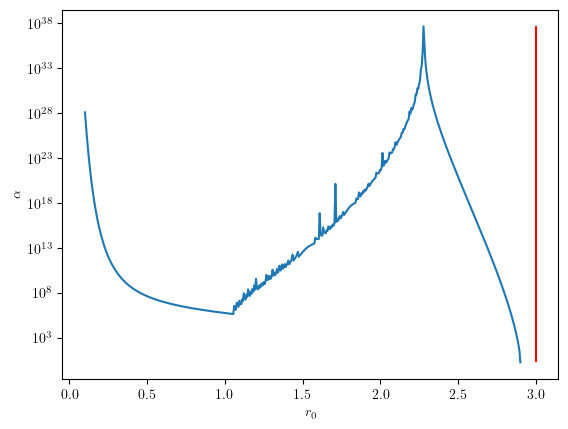

In [21]:
plt.plot(r0grid,alphagrid,label=r'$\alpha$')
plt.xlabel(r'$r_0$')
plt.ylabel(r'$\alpha$')
plt.vlines(R,alphagrid.min(),alphagrid.max(),colors='r',label="Horizon")
plt.semilogy()
# plt.xlim((9,10))
# plt.ylim((1,10))
plt.show()

In [22]:
#now just have to integrate our area functional from inf to R, from R to r0...
#i guess we can just do this a million billion times, varying alpha -> varying r0
#this will be so fun yippee!!!!

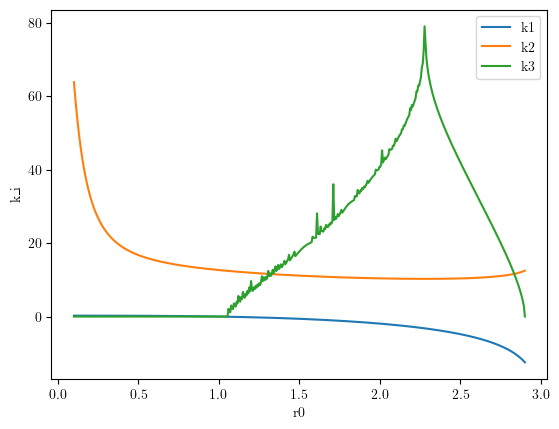

In [23]:
plt.plot(r0grid,k1grid,label='k1')
plt.plot(r0grid,k2grid,label='k2')
plt.plot(r0grid,k3grid,label='k3')
plt.xlabel('r0')
plt.ylabel('k_i')
plt.legend()
# plt.semilogx()
# plt.semilogy()
plt.show()

In [24]:
def det(rgrid,R):
    # rough estimate of r_crit in EQ 40 of 1405.7365
    eqgrid = fp(rgrid,R)*rgrid+(2*d-4)*f(rgrid,R)
    print(f'eqgrid: {eqgrid}')
    print(f'abseqgrid: {np.abs(eqgrid)}')
    minloc = np.argmin(np.abs(eqgrid))
    return eqgrid[minloc],rgrid[minloc]

In [25]:
det(np.linspace(0.001,R,1000000),R)

eqgrid: [-3.23999838e+08 -3.22065191e+08 -3.20147821e+08 ...  1.79999640e+02
  1.79999820e+02  1.80000000e+02]
abseqgrid: [3.23999838e+08 3.22065191e+08 3.20147821e+08 ... 1.79999640e+02
 1.79999820e+02 1.80000000e+02]


(0.00038568722945342415, 1.3676366696366697)

In [ ]:
# ok so like
# divergences are absolutely NOT what the taylor series in paper would suggest (except for k1 and like the rightmost bit of k2)
# k3 should blow up around 1.367 but certainly does not do that
# honestly tho i have no clue what is going on rn
# may f0 and r0 are bad who knows
# what if i need to write my own riemann integral to deal with the imaginary cases, if trapz is integrating over invalid spaces still then we could have issues / overestimates

In [32]:
# well if theres nothing i can do about that rn then i guess i should build the area integral huh
# for now we can just do it with varying r0, and then once the alpha function decides to behave we can modify a touch

In [33]:
# equation 44 of the paper
def areaInteg(rgrid,r0,R):
    return (rgrid**(d-2)) / np.sqrt(f(rgrid,R) + gamma2(r0,R)*(rgrid**(4-2*d)))

In [34]:
# if we let rdot blow up we get this first order term, math was done on my whiteboard once...
def divArea(rgrid,R):
    return (rgrid**(d-2)) / np.sqrt(f(rgrid,R))

In [41]:
def area(r0grid,R):
    areaList = []
    area1List = []
    area2List = []
    rgrid1 = np.logspace(np.log10(R+0.1),np.log10(rmax),num)
    divAreaInteg = divArea(rgrid1,R)
    for i in range(num):
        r0 = r0grid[i]
        rgrid2 = np.linspace(r0,R-0.1,num)
        areaInteg1 = areaInteg(rgrid1,r0,R) - divAreaInteg
        area1 = np.trapz(areaInteg1,rgrid1)
        areaInteg2 = areaInteg(rgrid2,r0,R)
        mask = np.isfinite(areaInteg2)
        area2 = np.trapz(areaInteg2[mask],rgrid2[mask])
        areaSum = (2 * area1) + (4 * area2)
        areaList.append(areaSum)
        area1List.append(area1)
        area2List.append(area2)
    return np.array(areaList), area1List, area2List

In [48]:
rgrid2 = np.linspace(1,R-0.1,num)

/var/folders/sf/wr1kbwcd5dj1bbcsxb86lz7w0000gn/T/ipykernel_44065/1978728994.py:5: RuntimeWarning: divide by zero encountered in divide
  return k - mu(R)/(r**(d-2)) + (q**2)/(r**(2*d-4)) + (r**2)/(l**2)
/var/folders/sf/wr1kbwcd5dj1bbcsxb86lz7w0000gn/T/ipykernel_44065/1978728994.py:5: RuntimeWarning: invalid value encountered in divide
  return k - mu(R)/(r**(d-2)) + (q**2)/(r**(2*d-4)) + (r**2)/(l**2)


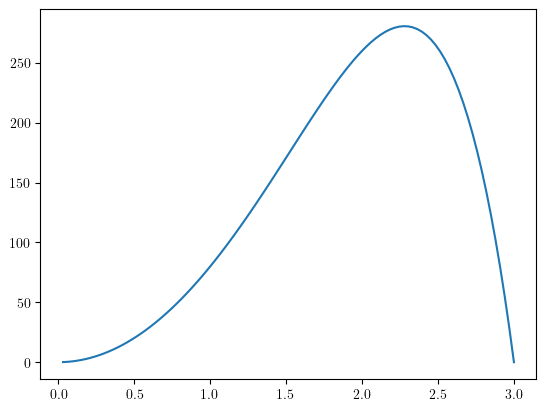

In [53]:
plt.plot(np.linspace(0,3,100),gamma2(np.linspace(0,3,100),3))

In [52]:
areaInteg2 = areaInteg(rgrid2,2,R)
areaInteg2

/var/folders/sf/wr1kbwcd5dj1bbcsxb86lz7w0000gn/T/ipykernel_44065/559195508.py:3: RuntimeWarning: invalid value encountered in sqrt
  return (rgrid**(d-2)) / np.sqrt(f(rgrid,R) + gamma2(r0,R)*(rgrid**(4-2*d)))


array([7.45355992e-02, 7.58026878e-02, 7.70877147e-02, 7.83909028e-02,
       7.97124775e-02, 8.10526672e-02, 8.24117034e-02, 8.37898205e-02,
       8.51872560e-02, 8.66042506e-02, 8.80410482e-02, 8.94978957e-02,
       9.09750435e-02, 9.24727454e-02, 9.39912585e-02, 9.55308434e-02,
       9.70917640e-02, 9.86742882e-02, 1.00278687e-01, 1.01905236e-01,
       1.03554214e-01, 1.05225903e-01, 1.06920590e-01, 1.08638566e-01,
       1.10380125e-01, 1.12145565e-01, 1.13935191e-01, 1.15749308e-01,
       1.17588229e-01, 1.19452270e-01, 1.21341751e-01, 1.23256997e-01,
       1.25198338e-01, 1.27166109e-01, 1.29160649e-01, 1.31182302e-01,
       1.33231418e-01, 1.35308351e-01, 1.37413462e-01, 1.39547115e-01,
       1.41709682e-01, 1.43901537e-01, 1.46123063e-01, 1.48374648e-01,
       1.50656685e-01, 1.52969574e-01, 1.55313719e-01, 1.57689533e-01,
       1.60097434e-01, 1.62537847e-01, 1.65011203e-01, 1.67517939e-01,
       1.70058501e-01, 1.72633341e-01, 1.75242918e-01, 1.77887698e-01,
      

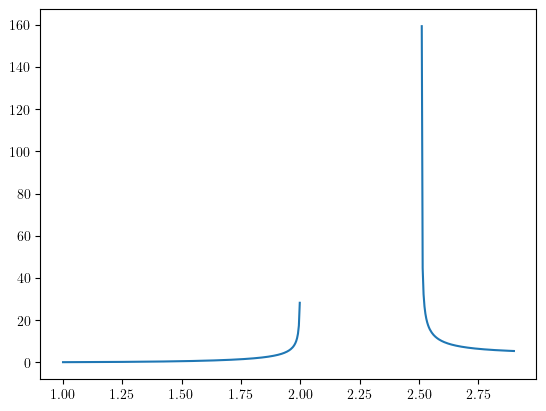

In [54]:
plt.plot(rgrid2,areaInteg2)

In [42]:
testArea, test1, test2 = area(r0grid,R)
testArea

/var/folders/sf/wr1kbwcd5dj1bbcsxb86lz7w0000gn/T/ipykernel_44065/559195508.py:3: RuntimeWarning: invalid value encountered in sqrt
  return (rgrid**(d-2)) / np.sqrt(f(rgrid,R) + gamma2(r0,R)*(rgrid**(4-2*d)))
/var/folders/sf/wr1kbwcd5dj1bbcsxb86lz7w0000gn/T/ipykernel_44065/559195508.py:3: RuntimeWarning: divide by zero encountered in divide
  return (rgrid**(d-2)) / np.sqrt(f(rgrid,R) + gamma2(r0,R)*(rgrid**(4-2*d)))


array([-1.03752043e-02, -1.15683763e-02, -1.28258154e-02, -1.41473867e-02,
       -1.55329486e-02, -1.69823530e-02, -1.84954453e-02, -2.00720645e-02,
       -2.17120434e-02, -2.34152084e-02, -2.51813799e-02, -2.70103721e-02,
       -2.89019930e-02, -3.08560449e-02, -3.28723242e-02, -3.49506213e-02,
       -3.70907213e-02, -3.92924032e-02, -4.15554407e-02, -4.38796022e-02,
       -4.62646506e-02, -4.87103435e-02, -5.12164333e-02, -5.37826675e-02,
       -5.64087884e-02, -5.90945338e-02, -6.18396362e-02, -6.46438238e-02,
       -6.75068200e-02, -7.04283439e-02, -7.34081100e-02, -7.64458287e-02,
       -7.95412061e-02, -8.26939442e-02, -8.59037411e-02, -8.91702910e-02,
       -9.24932842e-02, -9.58724075e-02, -9.93073440e-02, -1.02797773e-01,
       -1.06343372e-01, -1.09943813e-01, -1.13598766e-01, -1.17307897e-01,
       -1.21070872e-01, -1.24887350e-01, -1.28756990e-01, -1.32679447e-01,
       -1.36654374e-01, -1.40681422e-01, -1.44760239e-01, -1.48890471e-01,
       -1.53071761e-01, -

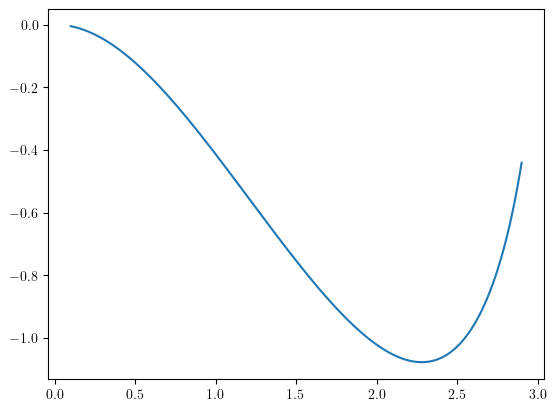

In [43]:
plt.plot(r0grid,test1)

[]

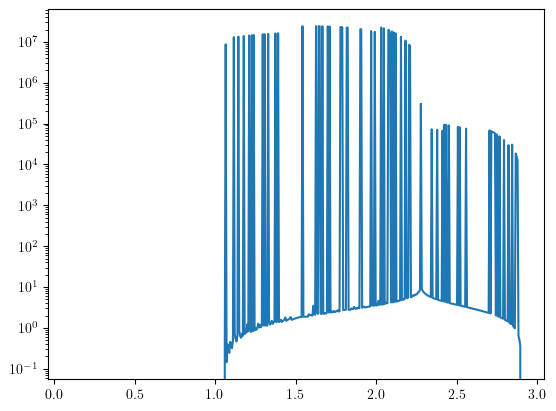

In [46]:
plt.plot(r0grid,test2)
plt.semilogy()

[]

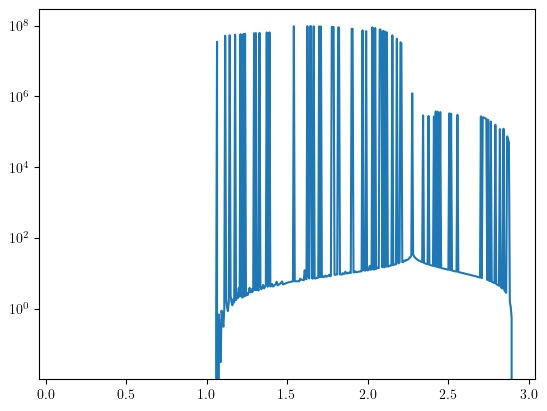

In [40]:
plt.plot(r0grid,testArea)
plt.semilogy()